# Introduction
I listen to a lot of music, and Spotify recently released their NLP song recommendation feature. I felt like this was the perfect feature for me because I often have a hard time finding music I enjoy, but I can describe the type of music I'm looking for. My initial motivation for this project was to try to recreate this feature as best I could, but quickly realized that may be out of its scope given the timeline. I chose a more manageable topic and would move on to the recommendation algorithm if I had time. I began by creating a Bi-directional LSTM which functioned as a music genre classifier with preprocessed lyrics as an input.

I wanted to work with big machine learning packages to familiarize myself and offload some of the detailed work. I chose tensorflow because i've worked with it in the past to perform image processing. NLTK will also be very useful during the preprocessing steps for my dataset.

#### Dataset

I chose this dataset because:
1. It's large (160 million samples)
2. Has the features I'm looking for (title, genre, artist, year, views, lyrics, and language)
3. Contains a limited number of genres (6)

I also don't have much experience with highly imbalanced datasets, so I wanted to challenge myself with that. 

https://www.kaggle.com/datasets/carlosgdcj/genius-song-lyrics-with-language-information?resource=download

#### Let's begin by importing all the required packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import time
from gensim.models import Word2Vec

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jason\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jason\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Next I check GPU availability and ensure Tensorflow/cudnn version compatibility

I'm working on my personal desktop and quickly found that CPU parallelized training was way too slow.

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow GPU support: ", tf.test.is_built_with_cuda())

import os
print("CUDA_VISIBLE_DEVICES:", os.environ.get('CUDA_VISIBLE_DEVICES'))

import tensorflow as tf
print("TensorFlow version:", tf.__version__)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

!nvidia-smi
!nvcc --version

Num GPUs Available:  1
TensorFlow GPU support:  True
CUDA_VISIBLE_DEVICES: None
TensorFlow version: 2.10.0
Tue Dec 10 13:19:49 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 Ti   WDDM  |   00000000:08:00.0  On |                  N/A |
|  0%   34C    P5             39W /  320W |    1318MiB /   8192MiB |     17%      Default |
|                                

#### Create a class to track metrics

Advantages of using Tensorflow's Callback:
1. Modularity
    1. Seperating the logic for computing and storing metrics from the main training loop makes the training code cleaner, modular, and easier to manage.
2. Integration with Tensorflow training
    1. Keras callbacks are designed to hook into specific points of the training process (on_epoch_begin, on_epoch_end, etc.).
    2. The callback system ensures the metrics are updated automatically at the right times without manual intervention.
3. Generator compatibility
    1. When working with generators for validation data, I can reset and manage the generator state properly (e.g., on_epoch_end).

In [3]:
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_gen=None, validation_steps=None):
        super(MetricsCallback, self).__init__()
        self.validation_gen = validation_gen
        self.validation_steps = validation_steps
        self.val_predictions = []
        self.val_true = []
    
    def on_epoch_end(self, epoch, logs=None):
        if self.validation_gen is None or self.validation_steps is None:
            return
        
        val_pred = []
        val_true = []
        
        # Reset the generator at the start of each epoch
        if hasattr(self.validation_gen, 'on_epoch_end'):
            self.validation_gen.on_epoch_end()
        
        # Collect predictions for the entire validation set
        for _ in range(self.validation_steps):
            try:
                batch_x, batch_y = next(self.validation_gen)
                batch_pred = self.model.predict(batch_x, verbose=0)
                val_pred.append(batch_pred)
                val_true.append(batch_y)
            except StopIteration:
                break
        
        if val_pred and val_true:
            # Concatenate all batches
            epoch_predictions = np.vstack(val_pred)
            epoch_true = np.concatenate(val_true)
            
            # Store predictions and true labels for this epoch
            self.val_predictions.append(epoch_predictions)
            self.val_true.append(epoch_true)
            
            # Add to logs
            logs['val_predictions'] = epoch_predictions
            logs['val_true'] = epoch_true

# Architecture Overview
The LargeLyricsClassifier is a neural network architecture which takes a memory-efficient approach to handle extensive text datasets while maintaining high performance through various optimization techniques.
#### Layers
1. Input embedding layer (configurable dimension, default 100)
2. Bidirectional LSTM layer with 64 units
3. Global max pooling
4. Batch normalization
5. Dense layer with dropout (64 units)
6. Softmax output layer

#### Technical Processes
##### Memory Management
Due to the large nature of the dataset, I need to implement chunked data processing using generators. I used three different generators for distinct phases of training.
1. Base generator
    1. The basic generator that handles standard batch processing
2. Split-Specific Generator
    1. Specialized generator that handles train/validation/test splits
    2. Uses predefined indices to know which samples belong to which split
3. Balanced Dataset Generator
    1. Focuses on creating a balanced dataset with equal representation from each class
    2. Not a true generator - returns a complete balanced DataFrame

I also employed mix precision training (float16/float32), tf.data.Dataset for efficient data streaming, and dynamic batch sizing.

##### Text Preprocessing
I use a relatively aggressive lyrics cleaning pipeline:
1. Word frequency filtering (minimum 5 occurrences)
2. Configurable maximum sequence length (default 200 tokens)
3. Vocabulary size limitation (default 10,000 words)
4. Custom tokenization with padding
5. Stop word removal and case normalization

I think this is the toughest part of this whole project. The lyrics include "metadata" in the form of labeling introductions and choruses: [Chorus: Opera Steve & Cam'ron], [Produced by Irv Gotti] [Intro], [Verse 1: Cam'ron], etc. It also becomes difficult to perform tokenization with slang, punctuation, and formatting. I don't explicitly remove slang or reformat, but perhaps that would increase the final accuracy.

##### Training Optimizations
1. Implements class balancing through stratified sampling
2. Uses adaptive learning rates (Adam optimizer)
3. Employs L2 regularization (coefficient: 1e-4)
4. Implements early stopping with patience=3
5. Includes model checkpointing for best weights
6. Supports distributed training through tf.distribute.MirroredStrategy

In [4]:
class LargeLyricsClassifier:
    def __init__(self, max_words=10000, max_len=200, embedding_dim=100, max_samples=1000000):
        self.max_words = max_words
        self.max_len = max_len
        self.embedding_dim = embedding_dim
        self.max_samples = max_samples  # Total maximum samples
        self.samples_per_genre = None  # Will be calculated based on number of genres
        self.tokenizer = None
        self.label_encoder = LabelEncoder()
        self.model = None
        self.history = None
        
        # Training split ratios
        self.train_ratio = 0.7
        self.val_ratio = 0.15
        self.test_ratio = 0.15
        
        # Store indices for each split
        self.train_indices = None
        self.val_indices = None
        self.test_indices = None
            
        # Enable mixed precision training
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)

    def count_total_samples(self, csv_path):
        """Count total number of samples in the dataset"""
        with open(csv_path, 'r', encoding='utf-8', errors='ignore') as f:
            total = sum(1 for _ in f) - 1  # subtract 1 for header
        return total if self.max_samples is None else min(total, self.max_samples)
    
    def create_splits(self, csv_path):
        """Create train/val/test splits and store the indices"""
        total_samples = self.count_total_samples(csv_path)
        
        print(f"Total samples in dataset: {total_samples}")
        
        # Create array of indices and shuffle
        indices = np.arange(1, total_samples + 1)  # start from 1 to skip header
        np.random.shuffle(indices)
        
        # Calculate split points
        train_end = int(total_samples * self.train_ratio)
        val_end = int(total_samples * (self.train_ratio + self.val_ratio))
        
        # Split indices
        self.train_indices = set(indices[:train_end])
        self.val_indices = set(indices[train_end:val_end])
        self.test_indices = set(indices[val_end:])
        
        print(f"\nDataset split created:")
        print(f"Train samples: {len(self.train_indices)}")
        print(f"Validation samples: {len(self.val_indices)}")
        print(f"Test samples: {len(self.test_indices)}")
    
    def preprocess_text(self, text):
        """
        More aggressive text preprocessing
        """
        if isinstance(text, pd.Series):
            # Fill NA values with empty string
            text = text.fillna("")
            
            # More aggressive cleaning
            text = text.str.lower()
            text = text.str.replace(r'[^\w\s]|\d+', ' ', regex=True)
            # Keep only words that appear at least 5 times in corpus
            text = text.str.split().map(lambda x: ' '.join(w for w in x 
                                                          if len(w) > 2 and w in self.frequent_words))
            # Limit to max 100 words per text
            text = text.str.split().map(lambda x: ' '.join(x[:100]))
            return text
        else:
            if pd.isna(text):
                return ""
            text = str(text).lower()
            text = re.sub(r'[^\w\s]|\d+', ' ', text)
            words = [w for w in text.split() if len(w) > 2 and w in self.frequent_words][:100]
            return ' '.join(words)

    def fit_preprocessing(self, csv_path, lyrics_col, tag_col, max_vocab_samples=None):
        """
        Fit preprocessing components including word frequency filtering, tokenizer, and label encoder.
        
        Parameters:
            csv_path: Path to CSV file
            lyrics_col: Name of lyrics column
            tag_col: Name of genre/tag column
            max_vocab_samples: Maximum samples to use for fitting tokenizer (None for all)
        """
        print("Fitting preprocessing components...")
        
        # First count word frequencies
        print("Counting word frequencies...")
        word_freq = Counter()
        total_processed = 0
        
        with tqdm(total=max_vocab_samples if max_vocab_samples else float('inf'), 
                  desc="Counting words", ncols=100) as pbar:
            for chunk in pd.read_csv(csv_path, usecols=[lyrics_col], chunksize=1000):
                if max_vocab_samples and total_processed >= max_vocab_samples:
                    break
                    
                for text in chunk[lyrics_col]:
                    if pd.isna(text):
                        continue
                    words = str(text).lower().split()
                    word_freq.update(words)
                    
                total_processed += len(chunk)
                pbar.update(len(chunk))
                if max_vocab_samples:
                    pbar.total = min(pbar.total, max_vocab_samples)
        
        # Keep words that appear at least 5 times
        self.frequent_words = {word for word, count in word_freq.items() if count >= 5}
        print(f"Found {len(self.frequent_words):,} frequent words")
        
        # Fit label encoder on all unique tags
        print("\nFitting label encoder...")
        all_tags = set()
        for chunk in pd.read_csv(csv_path, usecols=[tag_col], chunksize=10000):
            all_tags.update(chunk[tag_col].dropna().unique())
        
        self.label_encoder.fit(list(all_tags))
        print(f"Label encoder fitted. Number of classes: {len(self.label_encoder.classes_)}")
        print(f"Classes: {self.label_encoder.classes_}")
        
        # Then fit tokenizer on specified number of samples
        print("\nFitting tokenizer...")
        all_texts = []
        total_processed = 0
        
        with tqdm(total=max_vocab_samples if max_vocab_samples else float('inf'), 
                  desc="Processing texts", ncols=100) as pbar:
            for chunk in pd.read_csv(csv_path, usecols=[lyrics_col], chunksize=1000):
                if max_vocab_samples and total_processed >= max_vocab_samples:
                    break
                    
                # Process chunk using the new preprocessing with frequent words
                processed_texts = self.preprocess_text(chunk[lyrics_col])
                all_texts.extend(processed_texts)
                
                total_processed += len(chunk)
                pbar.update(len(chunk))
                if max_vocab_samples:
                    pbar.total = min(pbar.total, max_vocab_samples)
        
        self.tokenizer = Tokenizer(num_words=self.max_words)
        self.tokenizer.fit_on_texts(all_texts)
        print(f"\nTokenizer fitted on {total_processed:,} samples")
        print(f"Vocabulary size: {len(self.tokenizer.word_index):,}")
        
        # Save preprocessing objects
        self.save_preprocessing()
        
        # Print some statistics about the preprocessing
        print("\nPreprocessing Statistics:")
        print(f"Total unique words found: {len(word_freq):,}")
        print(f"Words appearing ≥5 times: {len(self.frequent_words):,}")
        print(f"Final vocabulary size: {min(self.max_words, len(self.tokenizer.word_index)):,}")
        print(f"Number of classes: {len(self.label_encoder.classes_)}")
        
        # Sample a few processed texts to show the effect
        print("\nExample processed texts:")
        sample_texts = all_texts[:3]  # Take first 3 processed texts
        for i, text in enumerate(sample_texts, 1):
            print(f"\nExample {i}: {text[:100]}...")  # Show first 100 chars

    def save_preprocessing(self, prefix=''):
        """Save tokenizer, label encoder, and frequent words to files"""
        import pickle
        
        tokenizer_path = f'{prefix}tokenizer.pkl'
        label_encoder_path = f'{prefix}label_encoder.pkl'
        frequent_words_path = f'{prefix}frequent_words.pkl'
        
        with open(tokenizer_path, 'wb') as f:
            pickle.dump(self.tokenizer, f)
        with open(label_encoder_path, 'wb') as f:
            pickle.dump(self.label_encoder, f)
        with open(frequent_words_path, 'wb') as f:
            pickle.dump(self.frequent_words, f)
        
        print(f"\nPreprocessing objects saved to {tokenizer_path}, {label_encoder_path}, and {frequent_words_path}")
    
    def load_preprocessing(self, prefix=''):
        """Load saved tokenizer, label encoder, and frequent words"""
        import pickle
        
        tokenizer_path = f'{prefix}tokenizer.pkl'
        label_encoder_path = f'{prefix}label_encoder.pkl'
        frequent_words_path = f'{prefix}frequent_words.pkl'
        
        with open(tokenizer_path, 'rb') as f:
            self.tokenizer = pickle.load(f)
        with open(label_encoder_path, 'rb') as f:
            self.label_encoder = pickle.load(f)
        with open(frequent_words_path, 'rb') as f:
            self.frequent_words = pickle.load(f)
        
        print(f"Loaded preprocessing objects from {tokenizer_path}, {label_encoder_path}, and {frequent_words_path}")
    
    def fit_tokenizer(self, csv_path, lyrics_col):
        """First pass: Fit the tokenizer on all texts"""
        print("First pass: Fitting tokenizer...")
        all_texts = []
        total_processed = 0
        
        # Calculate samples per genre
        _, self.samples_per_genre = self.get_genre_counts(csv_path, 'tag')
        
        # Process in chunks to handle large datasets
        chunk_size = 1000    
        with tqdm(total=self.max_samples, desc="Processing texts", 
                  position=0, leave=True, ncols=100, 
                  bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]') as pbar:
            for chunk in pd.read_csv(csv_path, usecols=[lyrics_col], chunksize=chunk_size):
                if total_processed >= self.max_samples:
                    break
                    
                # Process only remaining samples if near max_samples
                remaining = self.max_samples - total_processed
                if len(chunk) > remaining:
                    chunk = chunk.iloc[:remaining]
                
                processed_chunk = [self.preprocess_text(text) for text in chunk[lyrics_col]]
                all_texts.extend(processed_chunk)
                
                total_processed += len(chunk)
                pbar.update(len(chunk))
        
        self.tokenizer = Tokenizer(num_words=self.max_words)
        self.tokenizer.fit_on_texts(all_texts)
        print("\nTokenizer fitted.")
        print(f"Vocabulary size: {len(self.tokenizer.word_index)}")
    
    def fit_label_encoder(self, csv_path, tag_col):
        """First pass: Fit the label encoder on all tags"""
        print("Fitting label encoder...")
        all_tags = set()
        total_processed = 0
        
        # Process in chunks to handle large datasets
        chunk_size = 1000
        total_samples = self.count_total_samples(csv_path)
        
        with tqdm(total=total_samples, desc="Processing tags") as pbar:
            for chunk in pd.read_csv(csv_path, usecols=[tag_col], chunksize=chunk_size):
                if self.max_samples and total_processed >= self.max_samples:
                    break
                    
                # Process only remaining samples if near max_samples
                if self.max_samples:
                    remaining = self.max_samples - total_processed
                    if len(chunk) > remaining:
                        chunk = chunk.iloc[:remaining]
                
                all_tags.update(chunk[tag_col].dropna().unique())
                
                total_processed += len(chunk)
                pbar.update(len(chunk))
        
        self.label_encoder.fit(list(all_tags))
        print(f"Label encoder fitted. Number of classes: {len(self.label_encoder.classes_)}")
        print(f"Classes: {self.label_encoder.classes_}")
    
    def build_model(self, num_classes):
        """
        Simplified BiLSTM model
        """
        strategy = tf.distribute.MirroredStrategy()
        with strategy.scope():
            model = tf.keras.Sequential([
                # Embedding with strong regularization
                tf.keras.layers.Embedding(
                    self.max_words, 
                    100,  # Reduced embedding dimension
                    input_length=100,  # Reduced sequence length
                    embeddings_regularizer=tf.keras.regularizers.l2(1e-4)
                ),
                
                # Bidirectional LSTM with strong regularization
                tf.keras.layers.Bidirectional(
                    tf.keras.layers.LSTM(
                        64,  # Reduced units
                        return_sequences=True,
                        kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                        recurrent_regularizer=tf.keras.regularizers.l2(1e-4)
                    )
                ),
                
                tf.keras.layers.GlobalMaxPooling1D(),
                tf.keras.layers.BatchNormalization(),
                
                # Single dense layer with strong dropout
                tf.keras.layers.Dense(
                    64,
                    activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(1e-4)
                ),
                tf.keras.layers.Dropout(0.5),
                
                tf.keras.layers.Dense(num_classes, activation='softmax')
            ])
            
            model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Reduced learning rate
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
            )
        
        return model

    def calculate_class_weights(self, csv_path, tag_col, max_samples=None):
        """Calculate class weights with max_samples parameter"""
        print("\nCalculating class weights...")
        class_counts = Counter()
        samples_counted = 0
        
        for chunk in pd.read_csv(csv_path, chunksize=1000):
            class_counts.update(chunk[tag_col])
            samples_counted += len(chunk)
            
            if max_samples and samples_counted >= max_samples:
                break
        
        # Get max count for scaling
        max_count = max(class_counts.values())
        
        # Calculate weights more aggressively
        weights = {}
        for class_name, count in class_counts.items():
            idx = self.label_encoder.transform([class_name])[0]
            # More aggressive inverse weighting
            weight = (max_count / count) ** 1.5  # Exponential scaling
            weights[idx] = weight
        
        # Print class distribution and weights
        total_samples = sum(class_counts.values())
        print("\nClass distribution:")
        for class_name, count in class_counts.items():
            percentage = (count / total_samples) * 100
            idx = self.label_encoder.transform([class_name])[0]
            print(f"{class_name}: {count:,} samples ({percentage:.1f}%) - weight: {weights[idx]:.3f}")
        
        return weights
    
    def adjust_class_weights(self, weights, max_ratio=3.0):
        """
        Scale weights to prevent extreme values
        """
        # Find median weight as reference
        median_weight = np.median(list(weights.values()))
        
        # Scale weights relative to median
        scaled_weights = {}
        for class_idx, weight in weights.items():
            ratio = weight / median_weight
            if ratio > max_ratio:
                scaled_weights[class_idx] = median_weight * max_ratio
            elif ratio < 1/max_ratio:
                scaled_weights[class_idx] = median_weight / max_ratio
            else:
                scaled_weights[class_idx] = weight
        
        return scaled_weights
    
    def get_genre_counts(self, csv_path, tag_col):
        """Count number of genres and calculate samples per genre"""
        unique_genres = pd.read_csv(csv_path, usecols=[tag_col])[tag_col].unique()
        num_genres = len(unique_genres)
        self.samples_per_genre = self.max_samples // num_genres
        return unique_genres, self.samples_per_genre

    def prepare_dataset(self, texts, labels, batch_size=32):
        # Convert to tf.data.Dataset
        dataset = tf.data.Dataset.from_tensor_slices((texts, labels))
        dataset = dataset.shuffle(10000)
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)  # Enable prefetching
        return dataset
    
    def get_split_generator(self, csv_path, lyrics_col, tag_col, split='train', chunksize=32):
        """Generator that yields data for specified split"""
        if split == 'train':
            indices = self.train_indices
        elif split == 'val':
            indices = self.val_indices
        elif split == 'test':
            indices = self.test_indices
        else:
            raise ValueError("Split must be one of 'train', 'val', or 'test'")
        
        batch_x = []
        batch_y = []
        
        while True:  # Infinite generator for training
            try:
                # Try UTF-8 first
                for chunk in pd.read_csv(csv_path, encoding='utf-8', chunksize=100):  # Read larger chunks
                    # Process all samples in chunk
                    processed_lyrics = [self.preprocess_text(text) for text in chunk[lyrics_col]]
                    sequences = self.tokenizer.texts_to_sequences(processed_lyrics)
                    X = pad_sequences(sequences, maxlen=self.max_len)
                    y = self.label_encoder.transform(chunk[tag_col])
                    
                    # Add samples that belong to this split
                    for i, idx in enumerate(range(len(chunk))):
                        if idx in indices:
                            batch_x.append(X[i])
                            batch_y.append(y[i])
                            
                            # When we have enough samples, yield a batch
                            if len(batch_x) >= chunksize:
                                yield (np.array(batch_x[:chunksize]), 
                                      np.array(batch_y[:chunksize]))
                                batch_x = batch_x[chunksize:]
                                batch_y = batch_y[chunksize:]
                                
            except UnicodeDecodeError:
                # Fall back to latin-1 if UTF-8 fails
                for chunk in pd.read_csv(csv_path, encoding='latin-1', chunksize=100):
                    processed_lyrics = [self.preprocess_text(text) for text in chunk[lyrics_col]]
                    sequences = self.tokenizer.texts_to_sequences(processed_lyrics)
                    X = pad_sequences(sequences, maxlen=self.max_len)
                    y = self.label_encoder.transform(chunk[tag_col])
                    
                    for i, idx in enumerate(range(len(chunk))):
                        if idx in indices:
                            batch_x.append(X[i])
                            batch_y.append(y[i])
                            
                            if len(batch_x) >= chunksize:
                                yield (np.array(batch_x[:chunksize]), 
                                      np.array(batch_y[:chunksize]))
                                batch_x = batch_x[chunksize:]
                                batch_y = batch_y[chunksize:]
            
            # If we still have samples in the batch, pad it
            if batch_x:
                while len(batch_x) < chunksize:
                    batch_x.append(batch_x[0])  # Pad with copies of first example
                    batch_y.append(batch_y[0])
                yield (np.array(batch_x), np.array(batch_y))
                batch_x = []
                batch_y = []

    def prepare_data_generator(self, data, lyrics_col, tag_col, batch_size=32):
        """
        Create a generator that yields batches of data.
        data can be either a file path or a pandas DataFrame
        """
        def generate_batches():
            current_batch_texts = []
            current_batch_tags = []
            
            # If data is a DataFrame, process it directly
            if isinstance(data, pd.DataFrame):
                dataset = data
            else:
                # If data is a file path, read it
                dataset = pd.read_csv(data)
                
            # Process the entire dataset in batches
            for idx in range(0, len(dataset), batch_size):
                batch = dataset.iloc[idx:idx + batch_size]
                
                # Process batch
                batch_texts = self.preprocess_text(batch[lyrics_col])
                batch_tags = self.label_encoder.transform(batch[tag_col])
                
                # Convert texts to sequences
                sequences = self.tokenizer.texts_to_sequences(batch_texts)
                X = pad_sequences(sequences, maxlen=self.max_len)
                y = np.array(batch_tags)
                
                yield X, y
                
            # Loop back to the beginning
            while True:
                for idx in range(0, len(dataset), batch_size):
                    batch = dataset.iloc[idx:idx + batch_size]
                    
                    # Process batch
                    batch_texts = self.preprocess_text(batch[lyrics_col])
                    batch_tags = self.label_encoder.transform(batch[tag_col])
                    
                    # Convert texts to sequences
                    sequences = self.tokenizer.texts_to_sequences(batch_texts)
                    X = pad_sequences(sequences, maxlen=self.max_len)
                    y = np.array(batch_tags)
                    
                    yield X, y
        
        return generate_batches()
            
    def prepare_balanced_dataset(self, csv_path, lyrics_col, tag_col, max_samples):
        """
        Create a balanced dataset by sampling equally from each class up to max_samples
        """
        print("\nPreparing balanced dataset...")
        
        # First pass to count total samples per class
        class_counts = Counter()
        for chunk in pd.read_csv(csv_path, chunksize=1000):
            class_counts.update(chunk[tag_col])
        
        # Calculate samples per class to achieve balance
        n_classes = len(class_counts)
        samples_per_class = max_samples // n_classes
        print(f"\nTotal samples requested: {max_samples:,}")
        print(f"Samples per class: {samples_per_class:,}")
        
        # Create dictionary to store samples for each class
        balanced_data = {class_name: [] for class_name in class_counts.keys()}
        
        # Second pass to sample from each class
        for chunk in pd.read_csv(csv_path, chunksize=1000):
            for class_name in class_counts.keys():
                class_samples = chunk[chunk[tag_col] == class_name]
                if len(balanced_data[class_name]) < samples_per_class:
                    balanced_data[class_name].extend(class_samples.to_dict('records'))
                
                # Check if we have enough samples for all classes
                if all(len(samples) >= samples_per_class for samples in balanced_data.values()):
                    break
        
        # Combine all samples and shuffle
        all_samples = []
        for class_name, samples in balanced_data.items():
            samples = samples[:samples_per_class]  # Trim to exact count needed
            all_samples.extend(samples)
        
        # Convert to DataFrame and shuffle
        balanced_df = pd.DataFrame(all_samples)
        balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)
        
        # Print final distribution
        print("\nFinal class distribution:")
        class_dist = balanced_df[tag_col].value_counts()
        for class_name, count in class_dist.items():
            print(f"{class_name}: {count:,} samples ({count/len(balanced_df)*100:.1f}%)")
        
        return balanced_df
    
    def train(self, csv_path, lyrics_col, tag_col, epochs=5, batch_size=32, 
              validation_split=0.2, max_samples=None):
        """Modified train method to use balanced dataset and metrics callback"""
        
        if self.tokenizer is None or self.label_encoder is None:
            raise ValueError("Tokenizer and label encoder must be fitted first!")
        
        print("Starting training process...")
        
        # Create balanced dataset
        balanced_data = self.prepare_balanced_dataset(csv_path, lyrics_col, tag_col, max_samples)
        
        # Split into train/validation
        train_size = int((1 - validation_split) * len(balanced_data))
        train_data = balanced_data[:train_size]
        val_data = balanced_data[train_size:]
        
        print(f"\nTraining samples: {len(train_data):,}")
        print(f"Validation samples: {len(val_data):,}")
        
        # Build model
        print("\nBuilding model...")
        self.model = self.build_model(len(self.label_encoder.classes_))
        print("Model built successfully!")
        self.model.summary()
        
        # Create data generators
        train_gen = self.prepare_data_generator(train_data, lyrics_col, tag_col, batch_size)
        val_gen = self.prepare_data_generator(val_data, lyrics_col, tag_col, batch_size)
        
        # Calculate steps per epoch
        steps_per_epoch = len(train_data) // batch_size
        validation_steps = len(val_data) // batch_size
        
        # Initialize metrics callback
        metrics_callback = MetricsCallback(
            validation_gen=val_gen,
            validation_steps=validation_steps
        )
        
        # Train the model
        print("\nTraining model...")
        history = self.model.fit(
            train_gen,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            validation_data=val_gen,
            validation_steps=validation_steps,
            callbacks=[
                metrics_callback,  # Add the metrics callback
                tf.keras.callbacks.ModelCheckpoint(
                    'best_model.h5',
                    monitor='val_accuracy',
                    save_best_only=True,
                    mode='max',
                    verbose=1
                ),
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=3,
                    restore_best_weights=True
                )
            ]
        )
        
        # Add metrics callback data to history
        history.history['val_predictions'] = metrics_callback.val_predictions
        history.history['val_true'] = metrics_callback.val_true
        
        return history
    
    def load_saved_model(model_path='best_model.h5', tokenizer_path='tokenizer.pkl', 
                        label_encoder_path='label_encoder.pkl'):
        """Load a saved model and its associated preprocessing objects."""
        import pickle
        
        # Load the model
        model = tf.keras.models.load_model(model_path)
        
        # Load the tokenizer
        with open(tokenizer_path, 'rb') as f:
            tokenizer = pickle.load(f)
            
        # Load the label encoder
        with open(label_encoder_path, 'rb') as f:
            label_encoder = pickle.load(f)
            
        return model, tokenizer, label_encoder

def plot_metrics(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label='Training')
    axes[0].plot(history.history['val_accuracy'], label='Validation')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    
    # Plot loss
    axes[1].plot(history.history['loss'], label='Training')
    axes[1].plot(history.history['val_loss'], label='Validation')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

#### Metrics Plotting
1. Training progress plot
    1. Shows accuracy curves for both training and validation sets over epochs
    2. Helps visualize model convergence and potential overfitting
2. Confusion Matrix
    1. Helped me identify the initial class imbalance problem
3. Class distribution pie chart
    1. Shows the raw counts and percentages of each class in the overall sampled dataset.

In [5]:
def plot_training_metrics(history, classifier, batch_size=64):
    """
    Plot training metrics:
    - Training/validation accuracy and loss curves
    - Confusion matrix
    - Class distribution pie chart
    
    Parameters:
        history: Training history from model.fit()
        classifier: Instance of LargeLyricsClassifier
        batch_size: Batch size used during training
    """
    
    # Create figure for metrics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # 1. Plot training metrics
    ax1.plot(history.history['accuracy'], label='Training')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Get validation predictions from the last epoch
    val_pred = history.history.get('val_predictions', None)
    val_true = history.history.get('val_true', None)
    
    if val_pred is not None and val_true is not None:
        # Convert predictions to class indices
        y_pred = np.argmax(val_pred[-1], axis=1)
        y_true = val_true[-1]
        
        # Get class names
        class_names = classifier.label_encoder.classes_
        
        # 2. Plot confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names,
                   yticklabels=class_names,
                   ax=ax2)
        ax2.set_title('Confusion Matrix')
        ax2.set_xlabel('Predicted')
        ax2.set_ylabel('True')
        
        plt.tight_layout()
        plt.show()
        
        # Create separate figure for class distribution
        plt.figure(figsize=(10, 6))
        
        # Calculate class distribution
        class_counts = np.bincount(y_true)
        total_samples = len(y_true)
        
        # Create labels with percentages
        labels = [f"{class_names[i]}\n({count/total_samples*100:.1f}%)" 
                 for i, count in enumerate(class_counts)]
        
        # Plot pie chart
        plt.pie(class_counts, 
                labels=labels,
                autopct='%1.1f%%',
                colors=sns.color_palette('pastel', n_colors=len(class_names)))
        plt.title('Class Distribution in Validation Set')
        plt.axis('equal')
        plt.show()
        
        # Print classification metrics
        print("\nClassification Report:")
        print(classification_report(
            y_true,
            y_pred,
            target_names=class_names,
            zero_division=0
        ))
        
        # Print final metrics
        print("\nFinal Metrics:")
        print(f"Training Accuracy: {history.history['accuracy'][-1]:.4f}")
        print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
        print(f"Training Loss: {history.history['loss'][-1]:.4f}")
        print(f"Validation Loss: {history.history['val_loss'][-1]:.4f}")
    else:
        print("\nNo validation predictions available in history. Make sure to use the MetricsCallback during training.")
        ax2.text(0.5, 0.5, 'No validation data available',
                horizontalalignment='center',
                verticalalignment='center')
        plt.tight_layout()
        plt.show()

# First Training Attempt

My initial pass at training involved fitting the preprocessing models. So, I took 1 million samples from the dataset and trained the tokenizer and label encoder. Initially, I didn't save these, which made parameter tuning extremely expensive because I'd have to refit them everytime I changed something. Now, I save them so that I only have to fit them once, and can load them every time I want to train.

Intuitively, I wanted to train with as many samples as possible (~50 million). However, a couple of problems arose:
1. Training time took upwards of 6 hours
    1. Became impossible to tweak hyperparameters
3. Class imbalance
    1. There are only about 100k country samples, which caused lots of misclassifications in the final model
  
##### Addressing imbalanced classes
First, I tried to address this problem by undersampling the overrepresented classes. This caused the overall accuracy to drop to ~50%. Next, I tried keeping a high sample count and just weighting the classes such that the model paid attention to the underrepresented classes. This was suprisingly difficult to implement especially in combination with the generators, and didn't yield much of an improvement in accuracy. I settled on a form of undersampling, where if max_samples doesn't exceed the smallest class, then it is guaranteed to be a perfect balance of classes (see the second BiLSTM model). However, I still wanted to try a model with a high sample count to see the difference in accuracy.

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Ti, compute capability 8.6
Fitting preprocessing components...
Counting word frequencies...


Counting words: 100%|██████████████████████████████████| 1000000/1000000 [01:23<00:00, 11937.62it/s]


Found 1,042,681 frequent words

Fitting label encoder...
Label encoder fitted. Number of classes: 6
Classes: ['country' 'misc' 'pop' 'rap' 'rb' 'rock']

Fitting tokenizer...


Processing texts: 100%|█████████████████████████████████| 1000000/1000000 [02:54<00:00, 5742.76it/s]



Tokenizer fitted on 1,000,000 samples
Vocabulary size: 456,908

Preprocessing objects saved to tokenizer.pkl, label_encoder.pkl, and frequent_words.pkl

Preprocessing Statistics:
Total unique words found: 5,899,747
Words appearing ≥5 times: 1,042,681
Final vocabulary size: 10,000
Number of classes: 6

Example processed texts:

Example 1: chorus opera steve cam ron killa cam killa cam cam killa cam killa cam killa cam cam killa cam killa...

Example 2: produced irv gotti intro yeah hah yeah roc fella invite you somethin epic you know well hustle out s...

Example 3: maybe cause eatin and these bastards fiend for they grub carry pumps like serve gasoline these scrub...

Preprocessing objects saved to tokenizer.pkl, label_encoder.pkl, and frequent_words.pkl
Loaded preprocessing objects from tokenizer.pkl, label_encoder.pkl, and frequent_words.pkl
Starting training process...

Preparing balanced dataset...

Total samples requested: 5,000,000
Samples per class: 833,333

Final class distrib

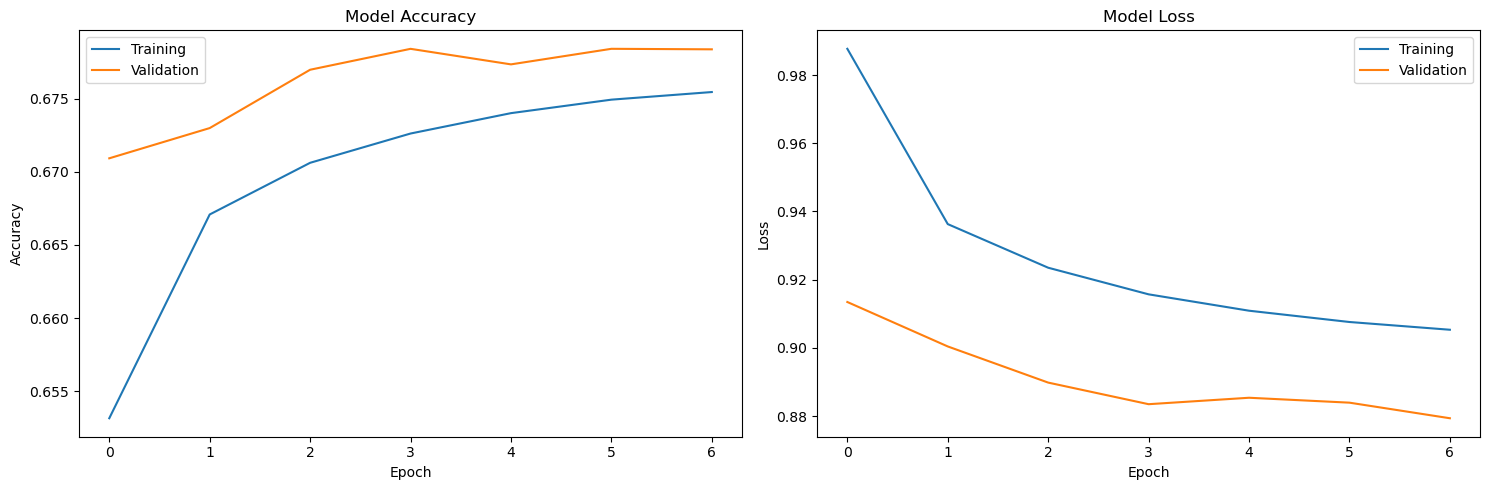

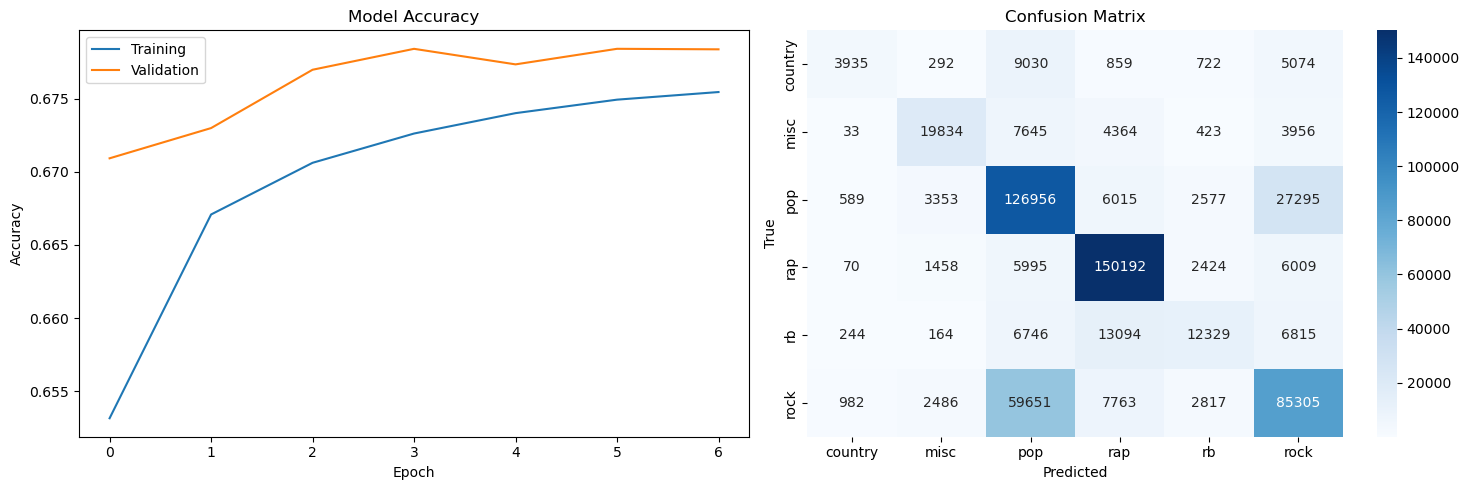

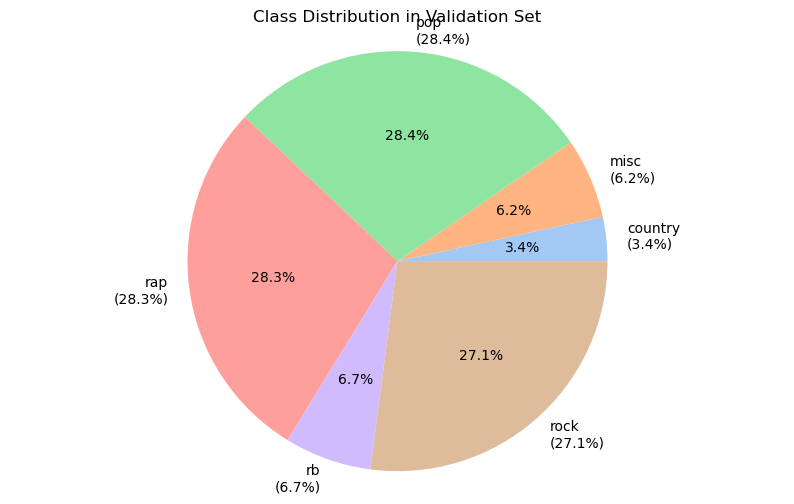


Classification Report:
              precision    recall  f1-score   support

     country       0.67      0.20      0.31     19912
        misc       0.72      0.55      0.62     36255
         pop       0.59      0.76      0.66    166785
         rap       0.82      0.90      0.86    166148
          rb       0.58      0.31      0.41     39392
        rock       0.63      0.54      0.58    159004

    accuracy                           0.68    587496
   macro avg       0.67      0.54      0.57    587496
weighted avg       0.68      0.68      0.67    587496


Final Metrics:
Training Accuracy: 0.6755
Validation Accuracy: 0.6784
Training Loss: 0.9053
Validation Loss: 0.8793


In [6]:
csv_path = 'song_lyrics.csv'
lyrics_col = 'lyrics'
tag_col = 'tag'

classifier = LargeLyricsClassifier(max_len=100, embedding_dim=100)
classifier.fit_preprocessing(
    csv_path='song_lyrics.csv',
    lyrics_col='lyrics',
    tag_col='tag',
    max_vocab_samples=1000000  # Optional: limit samples for vocabulary building
)

classifier.save_preprocessing()  # Save for later use

classifier.load_preprocessing()

# Train the model with validation
history = classifier.train(
    csv_path='song_lyrics.csv',
    lyrics_col='lyrics',
    tag_col='tag',
    max_samples=5000000,
    batch_size=128,
    epochs=7
)

plot_metrics(history)

plot_training_metrics(history, classifier, batch_size=64)

# Second Training Attempt

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Ti, compute capability 8.6
Loaded preprocessing objects from tokenizer.pkl, label_encoder.pkl, and frequent_words.pkl
Starting training process...

Preparing balanced dataset...

Total samples requested: 600,000
Samples per class: 100,000

Final class distribution:
country: 100,000 samples (16.7%)
rb: 100,000 samples (16.7%)
rock: 100,000 samples (16.7%)
rap: 100,000 samples (16.7%)
pop: 100,000 samples (16.7%)
misc: 100,000 samples (16.7%)

Training samples: 480,000
Validation samples: 120,000

Building model...
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce

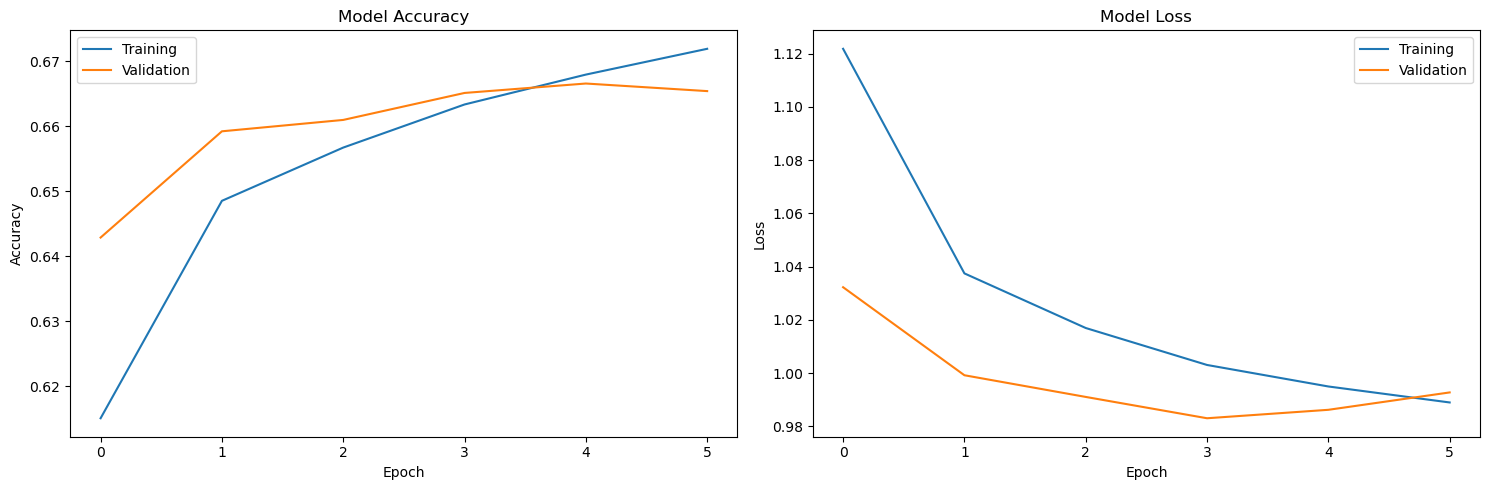

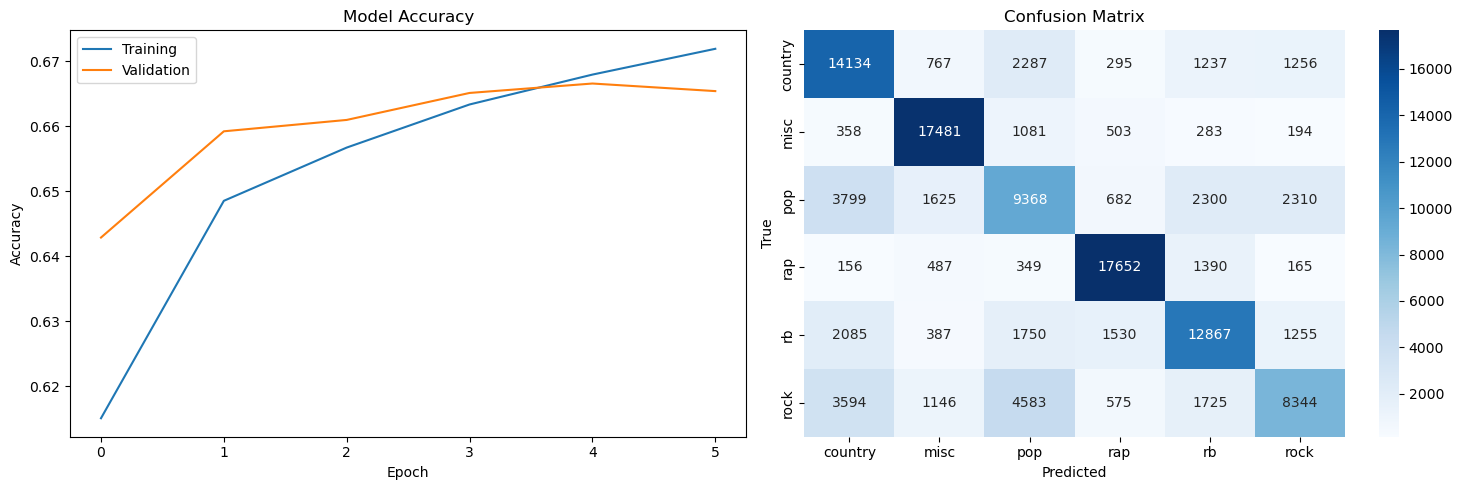

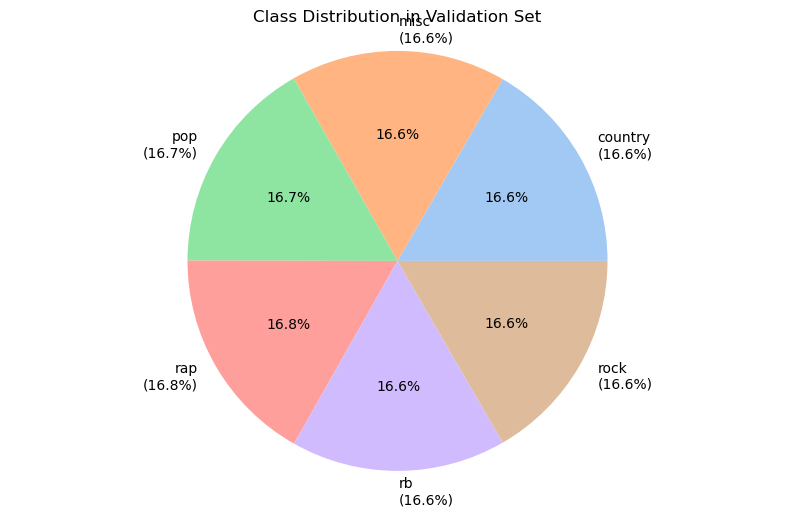


Classification Report:
              precision    recall  f1-score   support

     country       0.59      0.71      0.64     19976
        misc       0.80      0.88      0.84     19900
         pop       0.48      0.47      0.47     20084
         rap       0.83      0.87      0.85     20199
          rb       0.65      0.65      0.65     19874
        rock       0.62      0.42      0.50     19967

    accuracy                           0.67    120000
   macro avg       0.66      0.67      0.66    120000
weighted avg       0.66      0.67      0.66    120000


Final Metrics:
Training Accuracy: 0.6719
Validation Accuracy: 0.6654
Training Loss: 0.9889
Validation Loss: 0.9927


In [6]:
csv_path = 'song_lyrics.csv'
lyrics_col = 'lyrics'
tag_col = 'tag'

classifier = LargeLyricsClassifier(max_len=100, embedding_dim=100)

classifier.load_preprocessing()

# Train the model with validation
history = classifier.train(
    csv_path='song_lyrics.csv',
    lyrics_col='lyrics',
    tag_col='tag',
    max_samples=600000,
    batch_size=64,
    epochs=6
)

plot_metrics(history)

plot_training_metrics(history, classifier, batch_size=64)

#### Comparison Code

This code cell creates 4 more models to compare accuracies with the BiLSTM. Analysis is done in the results section below.

In [8]:
class ModelComparison:
    def __init__(self, lyrics_classifier, max_features=10000, max_len=100):
        self.lyrics_classifier = lyrics_classifier
        self.max_features = max_features
        self.max_len = max_len
        self.models = {}
        self.training_times = {}
        self.evaluation_metrics = defaultdict(dict)
        self.tfidf = TfidfVectorizer(max_features=max_features)
        
    def prepare_data_from_csv(self, csv_path, lyrics_col, tag_col, max_samples=100000):
        """Prepare balanced dataset from CSV using existing LargeLyricsClassifier logic"""
        print("Preparing balanced dataset...")
        
        # Use the existing balanced dataset preparation
        balanced_df = self.lyrics_classifier.prepare_balanced_dataset(
            csv_path=csv_path,
            lyrics_col=lyrics_col,
            tag_col=tag_col,
            max_samples=max_samples
        )
        
        # Split into train/val/test using the same ratios as LargeLyricsClassifier
        train_size = int(self.lyrics_classifier.train_ratio * len(balanced_df))
        val_size = int(self.lyrics_classifier.val_ratio * len(balanced_df))
        
        # Shuffle the data
        balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
        
        # Split the data
        train_df = balanced_df[:train_size]
        val_df = balanced_df[train_size:train_size + val_size]
        test_df = balanced_df[train_size + val_size:]
        
        # Prepare text and labels
        X_train = train_df[lyrics_col].apply(self.lyrics_classifier.preprocess_text)
        y_train = self.lyrics_classifier.label_encoder.transform(train_df[tag_col])
        
        X_val = val_df[lyrics_col].apply(self.lyrics_classifier.preprocess_text)
        y_val = self.lyrics_classifier.label_encoder.transform(val_df[tag_col])
        
        X_test = test_df[lyrics_col].apply(self.lyrics_classifier.preprocess_text)
        y_test = self.lyrics_classifier.label_encoder.transform(test_df[tag_col])
        
        print(f"\nPrepared dataset splits:")
        print(f"Train samples: {len(X_train)}")
        print(f"Validation samples: {len(X_val)}")
        print(f"Test samples: {len(X_test)}")
        
        return X_train, y_train, X_val, y_val, X_test, y_test

    def prepare_w2v_embeddings(self, texts, vector_size=100, window=5, min_count=1):
        """Prepare Word2Vec embeddings from texts"""
        # Tokenize texts
        tokenized_texts = [text.split() for text in texts]
        
        # Train Word2Vec
        w2v_model = Word2Vec(sentences=tokenized_texts, 
                           vector_size=vector_size,
                           window=window, 
                           min_count=min_count,
                           workers=4)
        
        # Create document vectors by averaging word vectors
        doc_vectors = []
        for text in tokenized_texts:
            vectors = []
            for word in text:
                if word in w2v_model.wv:
                    vectors.append(w2v_model.wv[word])
            if vectors:
                doc_vectors.append(np.mean(vectors, axis=0))
            else:
                doc_vectors.append(np.zeros(vector_size))
                
        return np.array(doc_vectors)

    def build_baseline_cnn(self, vocab_size, num_classes):
        """Build a lightweight CNN model"""
        model = Sequential([
            tf.keras.layers.Embedding(vocab_size, 50, input_length=self.max_len),
            Conv1D(64, 5, activation='relu'),
            GlobalAveragePooling1D(),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(num_classes, activation='softmax')
        ])
        model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
        return model

    def train_and_evaluate(self, X_train, y_train, X_val, y_val, X_test, y_test):
        """Train and evaluate multiple models"""
        
        # 1. Traditional ML with TF-IDF
        print("Preparing TF-IDF features...")
        X_train_tfidf = self.tfidf.fit_transform(X_train)
        X_val_tfidf = self.tfidf.transform(X_val)
        X_test_tfidf = self.tfidf.transform(X_test)
        
        # Logistic Regression
        print("\nTraining Logistic Regression...")
        start_time = time.time()
        lr_model = LogisticRegression(max_iter=1000)
        lr_model.fit(X_train_tfidf, y_train)
        self.training_times['logistic'] = time.time() - start_time
        self.models['logistic'] = lr_model
        
        # Evaluate
        self.evaluation_metrics['logistic'] = {
            'train_acc': lr_model.score(X_train_tfidf, y_train),
            'val_acc': lr_model.score(X_val_tfidf, y_val),
            'test_acc': lr_model.score(X_test_tfidf, y_test)
        }
        
        # Naive Bayes
        print("\nTraining Naive Bayes...")
        start_time = time.time()
        nb_model = MultinomialNB()
        nb_model.fit(X_train_tfidf, y_train)
        self.training_times['naive_bayes'] = time.time() - start_time
        self.models['naive_bayes'] = nb_model
        
        # Evaluate
        self.evaluation_metrics['naive_bayes'] = {
            'train_acc': nb_model.score(X_train_tfidf, y_train),
            'val_acc': nb_model.score(X_val_tfidf, y_val),
            'test_acc': nb_model.score(X_test_tfidf, y_test)
        }
        
        # 2. Word2Vec with Random Forest
        print("\nPreparing Word2Vec features...")
        start_time = time.time()
        X_train_w2v = self.prepare_w2v_embeddings(X_train)
        X_val_w2v = self.prepare_w2v_embeddings(X_val)
        X_test_w2v = self.prepare_w2v_embeddings(X_test)
        
        print("\nTraining Random Forest with Word2Vec...")
        rf_model = RandomForestClassifier(n_estimators=100)
        rf_model.fit(X_train_w2v, y_train)
        self.training_times['rf_w2v'] = time.time() - start_time
        self.models['rf_w2v'] = rf_model
        
        # Evaluate
        self.evaluation_metrics['rf_w2v'] = {
            'train_acc': rf_model.score(X_train_w2v, y_train),
            'val_acc': rf_model.score(X_val_w2v, y_val),
            'test_acc': rf_model.score(X_test_w2v, y_test)
        }
        
        # 3. Lightweight CNN
        print("\nTraining Lightweight CNN...")
        start_time = time.time()
        cnn_model = self.build_baseline_cnn(self.max_features + 1, len(np.unique(y_train)))
        
        # Prepare sequences for CNN using existing tokenizer
        sequences_train = self.lyrics_classifier.tokenizer.texts_to_sequences(X_train)
        sequences_val = self.lyrics_classifier.tokenizer.texts_to_sequences(X_val)
        sequences_test = self.lyrics_classifier.tokenizer.texts_to_sequences(X_test)
        
        X_train_seq = pad_sequences(sequences_train, maxlen=self.max_len)
        X_val_seq = pad_sequences(sequences_val, maxlen=self.max_len)
        X_test_seq = pad_sequences(sequences_test, maxlen=self.max_len)
        
        # Train CNN
        history = cnn_model.fit(
            X_train_seq, y_train,
            validation_data=(X_val_seq, y_val),
            epochs=10,
            batch_size=32,
            callbacks=[EarlyStopping(monitor='val_loss', patience=2)],
            verbose=1
        )
        
        self.training_times['cnn'] = time.time() - start_time
        self.models['cnn'] = cnn_model
        
        # Evaluate
        self.evaluation_metrics['cnn'] = {
            'train_acc': cnn_model.evaluate(X_train_seq, y_train, verbose=0)[1],
            'val_acc': cnn_model.evaluate(X_val_seq, y_val, verbose=0)[1],
            'test_acc': cnn_model.evaluate(X_test_seq, y_test, verbose=0)[1]
        }
        
    def plot_comparison(self):
        """Plot comparison of model performances and training times"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Prepare data for plotting
        models = list(self.evaluation_metrics.keys())
        train_acc = [self.evaluation_metrics[m]['train_acc'] for m in models]
        val_acc = [self.evaluation_metrics[m]['val_acc'] for m in models]
        test_acc = [self.evaluation_metrics[m]['test_acc'] for m in models]
        times = [self.training_times[m] for m in models]
        
        # Plot accuracies
        x = np.arange(len(models))
        width = 0.25
        
        ax1.bar(x - width, train_acc, width, label='Train')
        ax1.bar(x, val_acc, width, label='Validation')
        ax1.bar(x + width, test_acc, width, label='Test')
        
        ax1.set_ylabel('Accuracy')
        ax1.set_title('Model Performance Comparison')
        ax1.set_xticks(x)
        ax1.set_xticklabels(models, rotation=45)
        ax1.legend()
        
        # Plot training times
        ax2.bar(models, times)
        ax2.set_ylabel('Training Time (seconds)')
        ax2.set_title('Training Time Comparison')
        ax2.set_xticklabels(models, rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed metrics
        print("\nDetailed Performance Metrics:")
        metrics_df = pd.DataFrame(self.evaluation_metrics).T
        metrics_df.columns = ['Train Accuracy', 'Validation Accuracy', 'Test Accuracy']
        print(metrics_df.round(4))
        
        print("\nTraining Times (seconds):")
        times_df = pd.DataFrame.from_dict(self.training_times, orient='index', columns=['Time'])
        print(times_df.round(2))

Preparing balanced dataset...

Preparing balanced dataset...

Total samples requested: 100,000
Samples per class: 16,666

Final class distribution:
rock: 16,666 samples (16.7%)
pop: 16,666 samples (16.7%)
rb: 16,666 samples (16.7%)
rap: 16,666 samples (16.7%)
country: 16,666 samples (16.7%)
misc: 16,666 samples (16.7%)

Prepared dataset splits:
Train samples: 69997
Validation samples: 14999
Test samples: 15000
Preparing TF-IDF features...

Training Logistic Regression...

Training Naive Bayes...

Preparing Word2Vec features...

Training Random Forest with Word2Vec...

Training Lightweight CNN...
Epoch 1/10
2188/2188 [==============================] - 15s 5ms/step - loss: 1.1208 - accuracy: 0.5612 - val_loss: 0.9472 - val_accuracy: 0.6358
Epoch 2/10
2188/2188 [==============================] - 10s 4ms/step - loss: 0.9102 - accuracy: 0.6583 - val_loss: 0.9181 - val_accuracy: 0.6529
Epoch 3/10
2188/2188 [==============================] - 10s 4ms/step - loss: 0.8403 - accuracy: 0.6873 - va

C:\Users\Jason\AppData\Local\Temp\ipykernel_808772\3872044094.py:230: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(models, rotation=45)


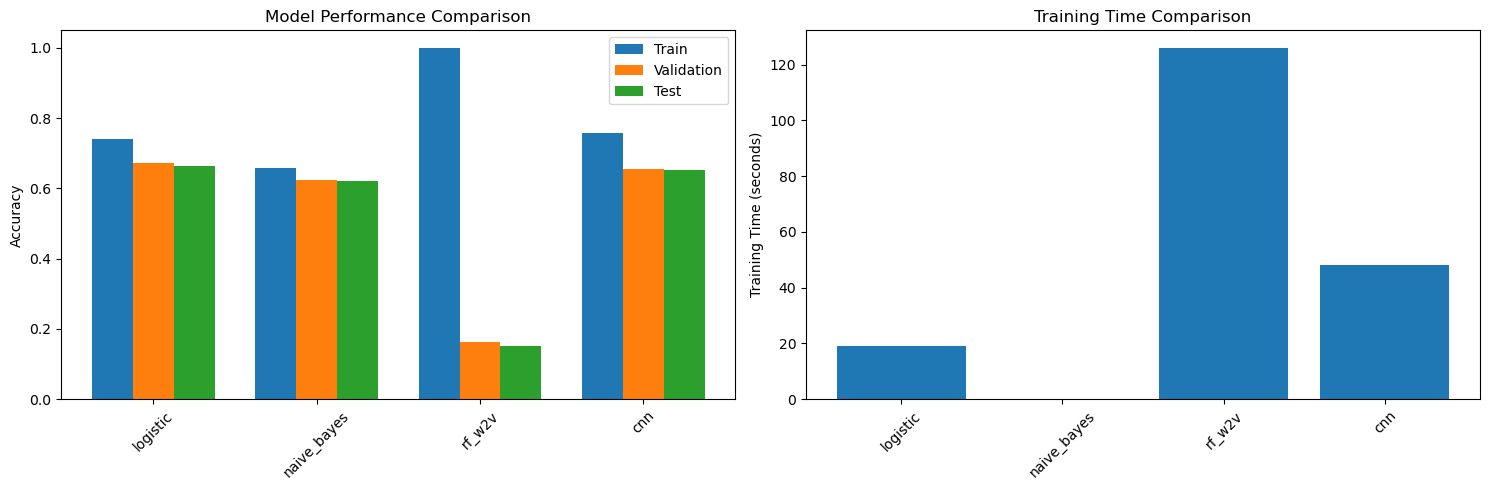


Detailed Performance Metrics:
             Train Accuracy  Validation Accuracy  Test Accuracy
logistic             0.7403               0.6729         0.6645
naive_bayes          0.6580               0.6228         0.6221
rf_w2v               0.9997               0.1638         0.1525
cnn                  0.7587               0.6557         0.6529

Training Times (seconds):
               Time
logistic      18.93
naive_bayes    0.03
rf_w2v       126.05
cnn           48.31


In [9]:
comparison = ModelComparison(lyrics_classifier=classifier)

# Prepare the data using the existing pipeline
X_train, y_train, X_val, y_val, X_test, y_test = comparison.prepare_data_from_csv(
    csv_path='song_lyrics.csv',
    lyrics_col='lyrics',
    tag_col='tag',
    max_samples=100000  # Adjust this based on your needs
)

# Train and evaluate all models
comparison.train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test)

# Plot the results
comparison.plot_comparison()

# Results

#### BiLSTM
##### Model 1
This model used a larger, imbalanced dataset of ~2.9 million samples. It showed decently strong performance for the majority classes. Rap had the best performance (0.86 F1-score) with high precision (0.82) and recall (0.90). Pop had moderate performance (0.66 F1-score) with lower precision (0.59) but good recall (0.76). There was generally poor performance for the minority classes. R&B had poor performance (0.41 F1-score) with low recall (0.31). Country had the worst performance (0.31 F1-score) due to very low recall (0.20). This model had an overall accuracy of 68%, but this is skewed by performance on majority classes. 

##### Model 2
This model used a balanced dataset of 600,000 samples. There was overall more balanced performance across classes: rap with a 0.85 F1-score, misc with a 0.84 F1-score, country with a 0.64 F1-score, and R&B with a 0.65 F1-score. The overall accuracy of 67% was similar to the first model, but with significantly more balanced performance. The higher validation loss (0.99 vs 0.88) suggests less overfitting. I think this model is preferable considering the significantly shorter training time and better generalization.

#### Traditional Model Analysis
##### Logistic Regression
This was the best performing traditional model with a 66% test accuracy. There seemed to be a decent balance between performance and training time. I think logistic regression had suprisingly good performance because it uses TF-IDF features that capture word importance, it can learn strong genre-specific vocabulary associations, and is especially effective when genre vocabulary is distinctive.

##### Naive Bayes
This model showed a slightly worse performance with a test accuracy of 62%. However, it had extremely fast training time, finishing in 0.03 seconds. I believe with appropriate preprocessing techniques and hyperparameter tuning, this model could be a strong contender.

##### Random Forest with Word2Vec
This model performed the worst with a test accuracy of 15%. It showed signs of severe overfitting considering the training accuracy was very high but the test accuracy was very low. It also had the longest training time of ~2 minutes. This is clearly not the correct architecture for this task.

##### CNN
This model showed competetive performance with a test accuracy of 65%. It had moderate training time of ~48 seconds. However, I see no reason to use this architecture over logistic regression.

#### Comparison
##### Performance
1. BiLSTM models performed best overall (0.67-0.68 accuracy)
2. Logistic Regression came close (0.66 accuracy) with simpler architecture
3. Random Forest with Word2Vec showed poorest generalization

##### Class Balance
1. Balanced BiLSTM (Model 2) showed more consistent performance across classes
2. Imbalanced BiLSTM (Model 1) favored majority classes
3. This suggests class balancing was effective for improving minority class performance

##### Efficiency
1. Naive Bayes offers best performance/time trade-off
2. BiLSTM models require significant training resources
3. Random Forest with Word2Vec showed poor efficiency given its performance

# Conclusions
#### Use the balanced BiLSTM (Model 2) if:
1. Equal performance across all genres is important
2. Computing resources are available
3. Maximum overall performance is needed


#### Use Logistic Regression if:
1. Quick training and deployment is priority
2. Computing resources are limited
3. Slightly lower performance is acceptable


#### Consider ensemble approaches combining:
1. Logistic Regression's efficiency
2. BiLSTM's high performance
3. Naive Bayes's speed for real-time applications

I reviewed other code notebooks attempting the same multi-class classification task, and found that their overall accuracy was ~70%. I believe that the real difficulty in this task is performing proper data cleaning and preprocessing, so the training data is as meaningful as possible. Basic steps like removing punctuation, case conversion, etc. is necessary, but altering the structure of the data may prove to be beneficial. Below are some changes I would make given more time:
1. Remove or separately encode "[Chorus]", "[Verse]", "[Bridge]" markers
2. Handle repeated choruses - either keep one instance or weight them differently
3. Identify and handle ad-libs/background vocals (often in parentheses)
4. Remove performance instructions like "(x2)" or "repeat 4x"

While I wouldn't be satisfied relying on this model for classification given it's accuracy, I am happy that I performed comparison analysis with traditional models. Even though BiLSTMs are newer and more sophisticated, a simpler architecture like logistic regression or naive bayes can still compete for this task. A full grid search may prove to be valuable after considerably more data cleaning, to show which model truly performs the best.

# Music Recommender

This is my attempt at reproducing Spotify's music recommendation feature. I couldn't get it working before this assignment was due, but I still included it.

In [13]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import spacy
import re
from typing import List, Dict, Tuple

class SmartMusicRecommender:
    def __init__(self, df: pd.DataFrame):
        """
        Initialize the recommender system.
        
        Args:
            df: DataFrame with columns [title, artist, lyrics, genre, rating, year, views, language]
        """
        self.df = df
        self.bert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
        self.nlp = spacy.load('en_core_web_sm')
        
        # Precompute TFIDF matrices
        self.tfidf = TfidfVectorizer(
            max_features=5000,
            stop_words='english'
        )
        
        # Create combined text representation for each song
        self.df['combined_features'] = (
            df['title'].fillna('') + ' ' +
            df['artist'].fillna('') + ' ' +
            df['lyrics'].fillna('').apply(lambda x: ' '.join(x.split()[:100]))  # First 100 words
        )
        
        # Compute TFIDF matrix
        self.tfidf_matrix = self.tfidf.fit_transform(self.df['combined_features'])
        
        # Initialize genre embeddings
        self.genre_embeddings = self._compute_genre_embeddings()
        
        # Keywords for mood/style matching
        self.mood_keywords = {
            'hype': ['energetic', 'hype', 'party', 'intense', 'pump', 'energy', 'aggressive'],
            'chill': ['relaxing', 'chill', 'mellow', 'smooth', 'calm', 'peaceful'],
            'sad': ['sad', 'melancholic', 'emotional', 'heartbreak', 'pain'],
            'happy': ['happy', 'upbeat', 'cheerful', 'joyful', 'fun'],
            'romantic': ['love', 'romantic', 'passion', 'relationship', 'heart']
        }
    
    def _compute_genre_embeddings(self) -> Dict[str, np.ndarray]:
        """Compute BERT embeddings for each genre"""
        unique_genres = self.df['genre'].unique()
        embeddings = {}
        
        for genre in unique_genres:
            # Get embedding for genre name
            genre_desc = f"music in the {genre} genre"
            embedding = self.bert_model.encode([genre_desc])[0]
            embeddings[genre] = embedding
            
        return embeddings
    
    def _extract_preferences(self, query: str) -> Dict:
        """Extract user preferences from natural language query"""
        doc = self.nlp(query.lower())
        
        preferences = {
            'artist': None,
            'genre': None,
            'mood': None,
            'year': None
        }
        
        # Extract artist names (could be improved with named entity recognition training)
        artist_pattern = r"by\s+([^\s]+(?:\s+[^\s]+)?)"
        artist_match = re.search(artist_pattern, query.lower())
        if artist_match:
            preferences['artist'] = artist_match.group(1)
        
        # Extract genre
        query_embedding = self.bert_model.encode([query])[0]
        genre_scores = {}
        for genre, genre_embedding in self.genre_embeddings.items():
            similarity = cosine_similarity(
                query_embedding.reshape(1, -1),
                genre_embedding.reshape(1, -1)
            )[0][0]
            genre_scores[genre] = similarity
        
        preferences['genre'] = max(genre_scores.items(), key=lambda x: x[1])[0]
        
        # Extract mood
        query_words = set(query.lower().split())
        for mood, keywords in self.mood_keywords.items():
            if any(keyword in query_words for keyword in keywords):
                preferences['mood'] = mood
                break
        
        # Extract year if mentioned
        year_pattern = r'\b(19|20)\d{2}\b'
        year_match = re.search(year_pattern, query)
        if year_match:
            preferences['year'] = int(year_match.group())
        
        return preferences
    
    def _compute_similarity_scores(self, 
                                 preferences: Dict,
                                 top_k: int = 10) -> pd.DataFrame:
        """Compute similarity scores based on extracted preferences"""
        
        # Start with all songs
        scores = pd.DataFrame(index=self.df.index)
        scores['total_score'] = 0.0
        
        # 1. Content-based similarity
        if preferences['artist']:
            artist_mask = self.df['artist'].str.lower().str.contains(
                preferences['genre'], na=False
            )
            scores.loc[artist_mask, 'total_score'] += 2.0
        
        # 2. Genre matching
        if preferences['genre']:
            genre_mask = self.df['genre'] == preferences['genre']
            scores.loc[genre_mask, 'total_score'] += 1.5
        
        # 3. Year proximity (if specified)
        if preferences['year']:
            year_diff = abs(self.df['year'] - preferences['year'])
            year_score = 1 / (1 + year_diff)
            scores['total_score'] += year_score
        
        # 4. Rating and views boost
        scores['total_score'] += (self.df['rating'] / 5.0) * 0.5
        if 'views' in self.df.columns:
            view_score = (self.df['views'] - self.df['views'].min()) / \
                        (self.df['views'].max() - self.df['views'].min())
            scores['total_score'] += view_score * 0.3
        
        # Sort and get top_k
        top_songs = scores.nlargest(top_k, 'total_score')
        
        return top_songs.index.tolist()
    
    def get_recommendations(self, 
                          query: str,
                          top_k: int = 10) -> pd.DataFrame:
        """
        Get song recommendations based on natural language query.
        
        Args:
            query: Natural language query (e.g., "I like hype rap music by Drake")
            top_k: Number of recommendations to return
            
        Returns:
            DataFrame with recommended songs and their features
        """
        # Extract preferences from query
        preferences = self._extract_preferences(query)
        
        # Print extracted preferences for transparency
        print("Extracted Preferences:")
        for key, value in preferences.items():
            print(f"{key}: {value}")
        
        # Get recommendations
        top_indices = self._compute_similarity_scores(preferences, top_k)
        recommendations = self.df.iloc[top_indices].copy()
        
        # Add confidence scores
        query_embedding = self.bert_model.encode([query])[0]
        song_embeddings = self.bert_model.encode(recommendations['combined_features'].tolist())
        confidence_scores = cosine_similarity(
            query_embedding.reshape(1, -1),
            song_embeddings
        )[0]
        
        recommendations['confidence_score'] = confidence_scores
        
        # Sort by confidence
        recommendations = recommendations.sort_values(
            'confidence_score', ascending=False
        ).reset_index(drop=True)
        
        # Select and order columns for display
        display_columns = [
            'title', 'artist', 'genre', 'year', 'rating',
            'views', 'language', 'confidence_score'
        ]
        display_columns = [col for col in display_columns if col in recommendations.columns]
        
        return recommendations[display_columns]

    def explain_recommendation(self, 
                             query: str,
                             song_index: int) -> str:
        """
        Explain why a particular song was recommended.
        
        Args:
            query: Original query string
            song_index: Index of the song to explain
            
        Returns:
            String explanation of the recommendation
        """
        preferences = self._extract_preferences(query)
        song = self.df.iloc[song_index]
        
        explanations = []
        
        # Genre match
        if preferences['genre'] and song['genre'] == preferences['genre']:
            explanations.append(
                f"This song is in the {song['genre']} genre that you're looking for"
            )
        
        # Artist match
        if preferences['artist'] and preferences['artist'].lower() in song['artist'].lower():
            explanations.append(f"This is by {song['artist']} as requested")
        
        # Year match
        if preferences['year']:
            year_diff = abs(song['year'] - preferences['year'])
            if year_diff <= 5:
                explanations.append(
                    f"Released in {song['year']}, close to your preferred year {preferences['year']}"
                )
        
        # Rating and popularity
        if 'rating' in song:
            explanations.append(f"It has a rating of {song['rating']}/5")
        if 'views' in song and song['views'] > self.df['views'].median():
            explanations.append("It's a popular song with many views")
        
        # Combine explanations
        if explanations:
            explanation = "This song was recommended because: " + "; ".join(explanations) + "."
        else:
            explanation = "This song matches your general preferences based on content similarity."
            
        return explanation

C:\Users\Jason\miniconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Load your dataset
df = pd.read_csv('song_lyrics.csv')

# Initialize recommender
recommender = SmartMusicRecommender(df)

# Get recommendations
query = "I like hype rap music by Drake from 2020"
recommendations = recommender.get_recommendations(query, top_k=5)
print("\nRecommendations:")
print(recommendations)

# Get explanation for first recommendation
explanation = recommender.explain_recommendation(query, recommendations.index[0])
print("\nWhy this song?")
print(explanation)